In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV

from sklearn.ensemble import RandomForestRegressor

## Data Preprocessing

In [2]:
df = pd.read_csv('../data/voter_turnout_merged_all_states.csv')
print("shape: ",df.shape)
df.head()

shape:  (1492, 69)


,Residence_Addresses_City,elec_date,elec_year,elec_type,total_voters_asian,total_voters_black,total_voters_hispanic,total_voters_others,total_voters_white,voted_voters_asian,...,total_voters_college,total_voters_no_college,voted_voters_college,voted_voters_no_college,perc_turnout_college,perc_turnout_no_college,mean_age,voter_population,voted_voters,state
0,Oakland,2020_11_03,2020,General,30600.0,61476.0,37174.0,8628.0,83122,23041.0,...,80668,27989.0,71356,22543.0,88.456389,80.542356,47.829424,331652,172221,CA
1,Oakland,2018_11_06,2018,General,30600.0,61476.0,37174.0,8628.0,83122,14972.0,...,80668,27989.0,59248,17372.0,73.446720,62.067241,48.224196,331652,130249,CA
2,Oakland,2016_11_08,2016,General,30600.0,61476.0,37174.0,8628.0,83122,16057.0,...,80668,27989.0,60766,18951.0,75.328507,67.708743,46.819512,331652,135633,CA
3,Oakland,2014_11_04,2014,General,30600.0,61476.0,37174.0,8628.0,83122,8145.0,...,80668,27989.0,38216,10811.0,47.374424,38.625889,51.034918,331652,75153,CA
4,San Leandro,2020_11_03,2020,General,12705.0,5596.0,16028.0,2429.0,17780,9229.0,...,19051,10653.0,16014,8674.0,84.058580,81.423073,49.752550,70359,41879,CA


In [3]:
df.Residence_Addresses_City.nunique()

213

In [4]:

#replace all NAN for voted_voters and total_voters counts  with 0

for col in ['voted_voters_asian', 
            'voted_voters_black', 
            'voted_voters_hispanic', 
            'voted_voters_others', 
            'voted_voters_white', 
            'voted_voters_$1000-14999',
              'voted_voters_$15000-24999',
              'voted_voters_$25000-34999',
              'voted_voters_$35000-49999',
              'voted_voters_$50000-74999',
              'voted_voters_$75000-99999',
              'voted_voters_$100000-124999',
              'voted_voters_$125000-149999',
              'voted_voters_$150000-174999',
              'voted_voters_$175000-199999',
              'voted_voters_$200000-249999',
              'voted_voters_$250000+']:
    df[col] = df[col].fillna(0)
#double check to make sure the sum adds up
print(sum(df['voted_voters'] != df['voted_voters_asian'] + 
          df['voted_voters_black']+df['voted_voters_hispanic'] + 
          df['voted_voters_others'] + df['voted_voters_white']))

for col in ['total_voters_asian', 
            'total_voters_black', 
            'total_voters_hispanic', 
            'total_voters_others', 
            'total_voters_white',
           'total_voters_$1000-14999',
              'total_voters_$15000-24999',
              'total_voters_$25000-34999',
              'total_voters_$35000-49999',
              'total_voters_$50000-74999',
              'total_voters_$75000-99999',
              'total_voters_$100000-124999',
              'total_voters_$125000-149999',
              'total_voters_$150000-174999',
              'total_voters_$175000-199999',
              'total_voters_$200000-249999',
              'total_voters_$250000+']:
    df[col] = df[col].fillna(0)
        
# voter_population is calculated from census data for people over age 20
# calculate new total_voters columns that should be used instead.
df['total_voters'] = df['total_voters_asian'] + df['total_voters_black']+df['total_voters_hispanic'] + df['total_voters_others'] + df['total_voters_white']
print(sum(df['total_voters'] !=  df['voter_population']))
print(df.shape)
df = df.drop(columns = ['voter_population'])
print(df.shape)

0
1492
(1492, 70)
(1492, 69)


In [5]:
df.columns.values

array(['Residence_Addresses_City', 'elec_date', 'elec_year', 'elec_type',
       'total_voters_asian', 'total_voters_black',
       'total_voters_hispanic', 'total_voters_others',
       'total_voters_white', 'voted_voters_asian', 'voted_voters_black',
       'voted_voters_hispanic', 'voted_voters_others',
       'voted_voters_white', 'perc_turnout_asian', 'perc_turnout_black',
       'perc_turnout_hispanic', 'perc_turnout_others',
       'perc_turnout_white', 'FECDonors_TotalDonationsAmount',
       'FECDonors_NumberOfDonations', 'mean_donation',
       'total_voters_$1000-14999', 'total_voters_$100000-124999',
       'total_voters_$125000-149999', 'total_voters_$15000-24999',
       'total_voters_$150000-174999', 'total_voters_$175000-199999',
       'total_voters_$200000-249999', 'total_voters_$25000-34999',
       'total_voters_$250000+', 'total_voters_$35000-49999',
       'total_voters_$50000-74999', 'total_voters_$75000-99999',
       'voted_voters_$1000-14999', 'voted_voters_$1

In [6]:
#adding outcome features for income

df['perc_turnout_under_50k'] = (df['voted_voters_$1000-14999'] + 
                                df['voted_voters_$15000-24999'] + 
                                df['voted_voters_$25000-34999'] + 
                                df['voted_voters_$35000-49999']) / \
                               (df['total_voters_$1000-14999'] + 
                                df['total_voters_$15000-24999'] + 
                                df['total_voters_$25000-34999'] + 
                                df['total_voters_$35000-49999'])
            
df['perc_turnout_over_100k'] = (df['voted_voters_$100000-124999'] + 
                                df['voted_voters_$125000-149999'] + 
                                df['voted_voters_$150000-174999'] +  
                                df['voted_voters_$175000-199999'] + 
                                df['voted_voters_$200000-249999'] + 
                                df['voted_voters_$250000+']) / \
                               (df['total_voters_$100000-124999'] + 
                                df['total_voters_$125000-149999'] + 
                                df['total_voters_$150000-174999'] +  
                                df['total_voters_$175000-199999'] + 
                                df['total_voters_$200000-249999'] + 
                                df['total_voters_$250000+'])

df.head()

,Residence_Addresses_City,elec_date,elec_year,elec_type,total_voters_asian,total_voters_black,total_voters_hispanic,total_voters_others,total_voters_white,voted_voters_asian,...,voted_voters_college,voted_voters_no_college,perc_turnout_college,perc_turnout_no_college,mean_age,voted_voters,state,total_voters,perc_turnout_under_50k,perc_turnout_over_100k
0,Oakland,2020_11_03,2020,General,30600.0,61476.0,37174.0,8628.0,83122,23041.0,...,71356,22543.0,88.456389,80.542356,47.829424,172221,CA,221000.0,0.693252,0.852955
1,Oakland,2018_11_06,2018,General,30600.0,61476.0,37174.0,8628.0,83122,14972.0,...,59248,17372.0,73.446720,62.067241,48.224196,130249,CA,221000.0,0.478709,0.686407
2,Oakland,2016_11_08,2016,General,30600.0,61476.0,37174.0,8628.0,83122,16057.0,...,60766,18951.0,75.328507,67.708743,46.819512,135633,CA,221000.0,0.528991,0.692809
3,Oakland,2014_11_04,2014,General,30600.0,61476.0,37174.0,8628.0,83122,8145.0,...,38216,10811.0,47.374424,38.625889,51.034918,75153,CA,221000.0,0.273848,0.408208
4,San Leandro,2020_11_03,2020,General,12705.0,5596.0,16028.0,2429.0,17780,9229.0,...,16014,8674.0,84.058580,81.423073,49.752550,41879,CA,54538.0,0.770270,0.793565


In [7]:
#specify columns to use. Don't want to use data that already has turnout information
# 'FECDonors_TotalDonationsAmount' can be removed since it can be computed using mean_donation and FECDonors_NumberOfDonations
# update 11/21, added different outcome variables so that we can train models to predict tunout, perc white, age, income

use_cols = ['Residence_Addresses_City', 'state', 'elec_type', 
             'rcv', 'turnout', 'perc_turnout_white', 'mean_age', 'perc_turnout_under_50k',
           'perc_turnout_over_100k']


In [8]:
#define RCV and non-rcv cities
rcv_cities = ['Albany', 'Berkeley', 'Eureka', 'Oakland', 'Palm Desert', 'San Francisco', 'San Leandro',
             'Las Cruces', 'Santa Fe', 'Boulder', 'Burlington', 'Portland', 'Takoma Park', 'Bluffdale',
             'Payson', 'Cottonwood Heights', 'Salt Lake City', 'Sandy', 'Midvale', 'Draper', 'Lehi',
             'Springville', 'South Salt Lake', 'Magna', 'Heber', 'Millcreek', 'Riverton', 'St. Louis Park',
             'Bloomington', 'Minneapolis', 'Minnetonka']
non_rcv_cities = list(set(df['Residence_Addresses_City']) - set(rcv_cities))

In [9]:
#function to generate rcv labels
def label_rcv(row):
    if row['Residence_Addresses_City'] in rcv_cities:
        return 1
    else:
        return 0

In [10]:
#add rcv label
df['rcv'] = df.apply(lambda row: label_rcv(row), axis=1)

#add turnout column
df['turnout'] = df['voted_voters'] / df['total_voters']

#filter to usable columns (i.e. columns that do not show turnout)
df = df[use_cols]
df.head()

,Residence_Addresses_City,state,elec_type,rcv,turnout,perc_turnout_white,mean_age,perc_turnout_under_50k,perc_turnout_over_100k
0,Oakland,CA,General,1,0.779281,84.200332,47.829424,0.693252,0.852955
1,Oakland,CA,General,1,0.589362,69.622964,48.224196,0.478709,0.686407
2,Oakland,CA,General,1,0.613724,69.738457,46.819512,0.528991,0.692809
3,Oakland,CA,General,1,0.340059,42.601237,51.034918,0.273848,0.408208
4,San Leandro,CA,General,1,0.767887,82.328459,49.752550,0.770270,0.793565


In [11]:
#checking rows with missing values
df.columns[df.isna().any()].tolist()

['perc_turnout_under_50k']

In [12]:
#check rows with missing values
df[df['perc_turnout_under_50k'].isnull()]

,Residence_Addresses_City,state,elec_type,rcv,turnout,perc_turnout_white,mean_age,perc_turnout_under_50k,perc_turnout_over_100k
420,Timonium,MD,General,0,1.000000,100.0,62.555699,NaN,1.0
421,Timonium,MD,General,0,0.500000,60.0,71.290535,NaN,0.5
422,Timonium,MD,General,0,0.500000,60.0,69.297339,NaN,0.5
423,Timonium,MD,General,0,0.500000,60.0,67.284977,NaN,0.5
448,North Bethesda,MD,General,0,0.500000,50.0,50.697824,NaN,0.6
449,North Bethesda,MD,General,0,0.500000,75.0,51.076568,NaN,0.4
450,North Bethesda,MD,General,0,0.500000,75.0,49.083372,NaN,0.4
451,North Bethesda,MD,General,0,0.166667,25.0,70.884412,NaN,0.2


In [13]:
#drop rows with missing values (these rows look like they have very low turnout anyway)
df.dropna(inplace=True)
#checking rows with missing values
df.columns[df.isna().any()].tolist()

[]

In [14]:
#group by city and election type
df = df.groupby(['Residence_Addresses_City', 'elec_type','state'], as_index=False).mean()
# df.drop(columns=['Residence_Addresses_City'], inplace=True)

df.head()


,Residence_Addresses_City,elec_type,state,rcv,turnout,perc_turnout_white,mean_age,perc_turnout_under_50k,perc_turnout_over_100k
0,Adelphi,General,MD,0.0,0.455109,51.538988,54.184656,0.474739,0.501815
1,Alamogordo,General,NM,0.0,0.491373,51.930341,57.574886,0.489294,0.554673
2,Alamogordo,Local_or_Municipal,NM,0.0,0.114373,12.804169,61.541445,0.110822,0.138876
3,Alamosa,Consolidated_General,CO,0.0,0.348872,39.124792,56.419342,0.306489,0.432444
4,Alamosa,General,CO,0.0,0.596245,63.335756,51.515875,0.539032,0.687079


In [15]:
#examine data
print(df.shape)
df.describe()

(367, 9)


,rcv,turnout,perc_turnout_white,mean_age,perc_turnout_under_50k,perc_turnout_over_100k
count,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000
mean,0.152589,0.428463,45.408121,53.542897,0.454649,0.459249
std,0.360081,0.200541,20.712565,4.053082,0.208625,0.207019
min,0.000000,0.065370,7.666349,37.837298,0.047074,0.065155
25%,0.000000,0.232817,24.927844,50.799581,0.274327,0.250818
50%,0.000000,0.482363,51.637787,53.327358,0.483351,0.546255
75%,0.000000,0.599972,63.538320,56.549871,0.628539,0.637492
max,1.000000,0.756453,78.641634,63.042398,0.812635,0.774744


In [16]:
print(df.columns[df.isna().any()].tolist())

[]


# Census Data

In [17]:
cities = pd.read_csv('../data/cities.csv', usecols=['state_id', 'RCV', 'city_ascii',  
                                                   'population_proper',
                                                    'race_white', 
                                                    'education_college_or_above',
                                                    'age_median', 
                                                    'income_household_median'])
print(cities.state_id.unique())

CA_cities = pd.read_csv('../data/ca-cities.csv', usecols=['state_id', 'RCV', 'city_ascii', 
                                                          'race_white', 
                                                          'population_proper',
                                                          'education_college_or_above',
                                                          'age_median', 
                                                          'income_household_median'])

cities = pd.concat([cities, CA_cities])
cities = cities.rename(columns = {'RCV': 'rcv', 'city_ascii': 'Residence_Addresses_City',
                                 'state_id': 'state'})
cities['rcv'] = cities['rcv'].fillna(0)

cities.head()



['NM' 'CO' 'VT' 'ME' 'MD' 'UT' 'MN']


,rcv,Residence_Addresses_City,state,population_proper,age_median,income_household_median,education_college_or_above,race_white
0,0.0,Los Alamos,NM,12035,41.7,101399,66.5,84.4
1,0.0,Albuquerque,NM,558545,36.2,49878,34.3,73.6
2,0.0,Rio Rancho,NM,96159,38.1,63180,30.2,79.9
3,0.0,Farmington,NM,45450,32.9,55179,20.2,61.1
4,0.0,North Valley,NM,11999,48.1,50236,28.0,74.9


In [18]:
cities.describe()

,rcv,population_proper,age_median,income_household_median,education_college_or_above,race_white
count,913.000000,9.130000e+02,913.000000,913.000000,913.000000,913.000000
mean,0.033954,5.636355e+04,36.791566,73569.914567,33.390361,68.947426
std,0.181210,1.596584e+05,6.038693,29671.599317,18.023748,21.930579
min,0.000000,3.564000e+03,19.200000,23541.000000,1.800000,3.500000
25%,0.000000,1.548200e+04,33.000000,52136.000000,19.200000,56.100000
50%,0.000000,2.640500e+04,36.600000,67614.000000,31.300000,74.900000
75%,0.000000,5.876600e+04,40.500000,89446.000000,45.000000,86.700000
max,1.000000,3.999759e+06,75.300000,238750.000000,95.300000,98.700000


In [19]:
print(cities.columns)
print(cities.shape)


Index(['rcv', 'Residence_Addresses_City', 'state', 'population_proper',
       'age_median', 'income_household_median', 'education_college_or_above',
       'race_white'],
      dtype='object')
(913, 8)


In [20]:
selected_df = df[['rcv', 
                  'state', 
                  'Residence_Addresses_City', 
                  'elec_type',
                  'turnout', 
                  'perc_turnout_white', 
                  'mean_age', 
                  'perc_turnout_under_50k',
                  'perc_turnout_over_100k']]
print(selected_df.shape)
print(selected_df.Residence_Addresses_City.nunique())

selected_df = selected_df.merge(cities, 
                     on = ['Residence_Addresses_City', 'rcv', 'state'], how = 'left')
print(selected_df.shape)
print(selected_df.Residence_Addresses_City.nunique())


(367, 9)
211
(367, 14)
211


In [21]:
selected_df.head()

,rcv,state,Residence_Addresses_City,elec_type,turnout,perc_turnout_white,mean_age,perc_turnout_under_50k,perc_turnout_over_100k,population_proper,age_median,income_household_median,education_college_or_above,race_white
0,0.0,MD,Adelphi,General,0.455109,51.538988,54.184656,0.474739,0.501815,15898,33.9,68064,32.3,17.2
1,0.0,NM,Alamogordo,General,0.491373,51.930341,57.574886,0.489294,0.554673,31248,37.0,45531,20.1,79.1
2,0.0,NM,Alamogordo,Local_or_Municipal,0.114373,12.804169,61.541445,0.110822,0.138876,31248,37.0,45531,20.1,79.1
3,0.0,CO,Alamosa,Consolidated_General,0.348872,39.124792,56.419342,0.306489,0.432444,9871,27.3,32785,25.3,83.4
4,0.0,CO,Alamosa,General,0.596245,63.335756,51.515875,0.539032,0.687079,9871,27.3,32785,25.3,83.4


In [22]:
#one-hot encode categorical cols
cat_cols = ['elec_type', 'state']

selected_df = pd.get_dummies(data=selected_df, columns=cat_cols)
print(selected_df.shape)
selected_df.head()


(367, 23)


,rcv,Residence_Addresses_City,turnout,perc_turnout_white,mean_age,perc_turnout_under_50k,perc_turnout_over_100k,population_proper,age_median,income_household_median,...,elec_type_General,elec_type_Local_or_Municipal,state_CA,state_CO,state_MD,state_ME,state_MN,state_NM,state_UT,state_VT
0,0.0,Adelphi,0.455109,51.538988,54.184656,0.474739,0.501815,15898,33.9,68064,...,1,0,0,0,1,0,0,0,0,0
1,0.0,Alamogordo,0.491373,51.930341,57.574886,0.489294,0.554673,31248,37.0,45531,...,1,0,0,0,0,0,0,1,0,0
2,0.0,Alamogordo,0.114373,12.804169,61.541445,0.110822,0.138876,31248,37.0,45531,...,0,1,0,0,0,0,0,1,0,0
3,0.0,Alamosa,0.348872,39.124792,56.419342,0.306489,0.432444,9871,27.3,32785,...,0,0,0,1,0,0,0,0,0,0
4,0.0,Alamosa,0.596245,63.335756,51.515875,0.539032,0.687079,9871,27.3,32785,...,1,0,0,1,0,0,0,0,0,0


# Model Implementation: Turnout

In [23]:
# split the data in 80:20 for train:test dataset
train_size=0.8

X = selected_df.drop(columns=['turnout',
                              'Residence_Addresses_City', 
                              'perc_turnout_white', 
                              'mean_age', 
                              'perc_turnout_under_50k',
                              'perc_turnout_over_100k'])
y = df['turnout']

# In the first step we will split the data in training and remaining dataset
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8)

print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_test.shape)

(293, 17)
(293,)
(74, 17)
(74,)


(None, None)

### Random Forest

In [24]:
# Import library for metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

#implement random forest
rf = RandomForestRegressor()

# n_estimators (The number of trees in the forest) default is 100, set 10, 20, 30 
# max_features: “auto”=n_features, “sqrt” =sqrt(n_features), “log2”=log2(n_features)

tuned_parameters = {'n_estimators': [10, 50, 100], 'max_depth': [None, 2, 3], 'max_features': [4, 8, 16, 20, 24]}
    
clf = GridSearchCV(RandomForestRegressor(bootstrap = True, random_state = 0), 
                   tuned_parameters, cv=5, 
                   n_jobs=-1, verbose=1)

clf.fit(X_train, y_train)

clf.score(X_train, y_train)
best_params = clf.best_params_ 
best_params

Fitting 5 folds for each of 45 candidates, totalling 225 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.90614912 0.92223046 0.9247933  0.92034371 0.9310415  0.93341225
 0.92721201 0.93081019 0.93284941        nan        nan        nan
        nan        nan        nan 0.73157906 0.73288518 0.74383069
 0.84539437 0.84830703 0.84922619 0.86421296 0.86524833 0.86443325
        nan        nan        nan        nan        nan        nan
 0.85042383 0.84819589 0.8380342  0.88619618 0.89048053 0.89133619
 0.89281102 0.8967501  0.89695527        nan        nan        nan
        nan        nan        nan]
  warnings.warn(


{'max_depth': None, 'max_features': 8, 'n_estimators': 100}

In [25]:
best_model = RandomForestRegressor(bootstrap = True, random_state = 0, max_depth= None, max_features= 8, n_estimators = 100)

best_model.fit(X_train, y_train)

train_pred = best_model.predict(X_train)
test_pred = best_model.predict(X_test)

def get_metrics(target, prediction):

    # Mean absolute error (MAE)
    mae = mean_absolute_error(target.values.ravel(), prediction)

    # Mean squared error (MSE)
    mse = mean_squared_error(target.values.ravel(), prediction)

    # R-squared scores
    r2 = r2_score(target.values.ravel(), prediction)

    # Print metrics
    print('Mean Absolute Error:', round(mae, 3))
    print('Mean Squared Error:', round(mse, 3))
    print('R-squared scores:', round(r2, 3))
    return pd.DataFrame([['Mean_Absolute_Error', mae], ['Mean_Squared_Error', mse], ['R_squared_score', r2]])
    
print("Train")
rf_overall_train = get_metrics(y_train, train_pred)
rf_overall_train.columns = ['metric', 'rf_overall_train']

print("Test")
rf_overall_test = get_metrics(y_test, test_pred)
rf_overall_test.columns = ['metric', 'rf_overall_test']

Train
Mean Absolute Error: 0.014
Mean Squared Error: 0.0
R-squared scores: 0.992
Test
Mean Absolute Error: 0.039
Mean Squared Error: 0.003
R-squared scores: 0.934


In [26]:
#function to generate and print ordered list of feature importance scores
def ordered_feature_importance(features, feature_importances, n=10):
    features = list(features)
    feature_importance = list(feature_importances)
    
    zipped = zip(features, feature_importance)
    sorted_zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
    
    unzipped = list(zip(*sorted_zipped))
    sorted_features = list(unzipped[0])
    sorted_feature_importance = list(unzipped[1])

    for i in range(n):
        print('Feature {} ({}) importance: {}'.format(i, sorted_features[i], sorted_feature_importance[i]))
    
    return sorted_features, sorted_feature_importance
sorted_features, sorted_feature_importance = ordered_feature_importance(X.columns, best_model.feature_importances_, n=len(X.columns))


Feature 0 (elec_type_General) importance: 0.5182689925718736
Feature 1 (elec_type_Consolidated_General) importance: 0.15910804767866377
Feature 2 (elec_type_Local_or_Municipal) importance: 0.09845897793123594
Feature 3 (education_college_or_above) importance: 0.05819239335944208
Feature 4 (state_CO) importance: 0.028300643605805975
Feature 5 (age_median) importance: 0.026519859783668304
Feature 6 (race_white) importance: 0.02373329102193692
Feature 7 (state_MN) importance: 0.021821786180505693
Feature 8 (income_household_median) importance: 0.020419633478669767
Feature 9 (state_NM) importance: 0.02011842425110469
Feature 10 (population_proper) importance: 0.010818277631327542
Feature 11 (state_VT) importance: 0.003850946574393721
Feature 12 (state_UT) importance: 0.0036085800316436384
Feature 13 (state_CA) importance: 0.0023850001016416014
Feature 14 (state_MD) importance: 0.0016335521666342994
Feature 15 (rcv) importance: 0.0013814735794131423
Feature 16 (state_ME) importance: 0.00138

In [27]:
# #plot feature importance
# plt.bar(np.arange(len(sorted_feature_importance)), sorted_feature_importance)
# plt.xticks(rotation = 0) 
# plt.title('Random Forest Feature Importance')
# plt.ylabel('Feature importance')
# plt.xlabel('Ordered feature number')

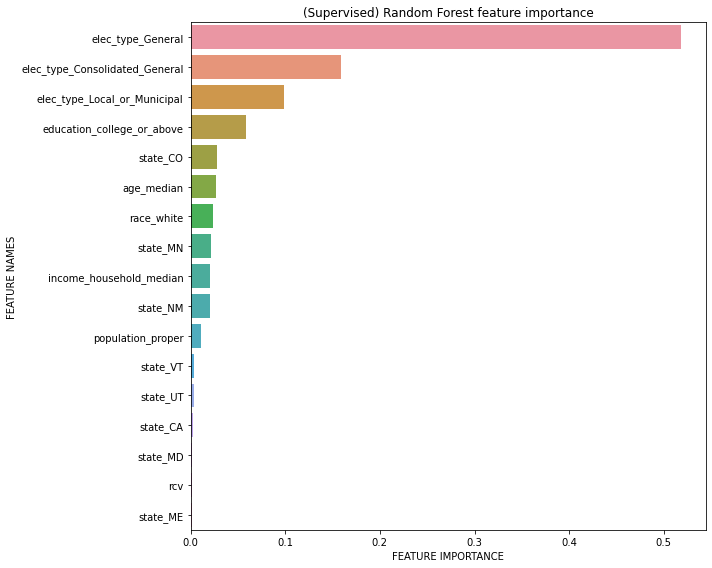

In [28]:
import seaborn as sns 
def plot_feature_importance(importance,names,fig_title, file_name):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(fig_title)
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.tight_layout()
    #plt.savefig(f'../data/plots/{file_name}.jpg')

plot_feature_importance(best_model.feature_importances_, X.columns,
                        fig_title = '(Supervised) Random Forest feature importance', 
                        file_name = 'RF_feature_imp_supervised_overall')


### How does feature importance differ between RCV and Non RCV (for turnout)?

### RCV

In [29]:
#implement random forest

rcv_df = selected_df[selected_df['rcv'] == 1]
rcv_target = rcv_df['turnout']
rcv_data = rcv_df.drop(columns=['turnout', 'rcv','Residence_Addresses_City'])

rcv_rf = RandomForestRegressor(bootstrap = True, oob_score = True, random_state = 0, 
                               max_depth= None, max_features= 8, n_estimators = 100)
rcv_rf.fit(rcv_data, rcv_target)

rcv_pred = rcv_rf.predict(rcv_data)

def get_metrics_CV(model, data, target):
    mae = -round(np.mean(cross_val_score(model, data, target, 
                                   scoring='neg_mean_absolute_error', cv=10, n_jobs=-1)), 3)
    mse = -round(np.mean(cross_val_score(model, data, target, 
                                   scoring='neg_mean_squared_error', cv=10, n_jobs=-1)), 3)
    r2 = round(np.mean(cross_val_score(model, data, target, 
                                  scoring='r2', cv=10, n_jobs=-1)), 3)
    
    
    print("Cross validation Mean Absolute Error score:", mae)
    print("Cross validation Mean Squared Error score:", mse)
    print("Cross validation R-sqaured score:", r2)
    return pd.DataFrame([['Mean_Absolute_Error', mae], ['Mean_Squared_Error', mse], ['R_squared_score', r2]])

print("RCV Cross Validation")
rf_rcv_cv = get_metrics_CV(rcv_rf, rcv_data, rcv_target)
rf_rcv_cv.columns = ['metric', 'rf_rcv_cv']
print(rf_rcv_cv)


RCV Cross Validation
Cross validation Mean Absolute Error score: 0.019
Cross validation Mean Squared Error score: 0.001
Cross validation R-sqaured score: 0.977
                metric  rf_rcv_cv
0  Mean_Absolute_Error      0.019
1   Mean_Squared_Error      0.001
2      R_squared_score      0.977


In [30]:
#generate and print ordered list of feature importance scores
rcv_sorted_features, rcv_sorted_feature_importance = ordered_feature_importance(rcv_data.columns, rcv_rf.feature_importances_, n=len(rcv_data.columns))

Feature 0 (perc_turnout_white) importance: 0.35947060322758917
Feature 1 (perc_turnout_over_100k) importance: 0.265172437969602
Feature 2 (elec_type_General) importance: 0.12887227637860504
Feature 3 (perc_turnout_under_50k) importance: 0.12853024663533785
Feature 4 (elec_type_Consolidated_General) importance: 0.07239052165128329
Feature 5 (mean_age) importance: 0.010475681339564691
Feature 6 (income_household_median) importance: 0.00756765997524898
Feature 7 (education_college_or_above) importance: 0.007117545069803255
Feature 8 (elec_type_Local_or_Municipal) importance: 0.004977099887693473
Feature 9 (age_median) importance: 0.00395781007462505
Feature 10 (state_CA) importance: 0.003207116782755578
Feature 11 (population_proper) importance: 0.0024508376128631985
Feature 12 (race_white) importance: 0.0021470076215239545
Feature 13 (state_MN) importance: 0.0015653791696434477
Feature 14 (state_CO) importance: 0.0009305339110526028
Feature 15 (state_UT) importance: 0.0004556113580293338

In [31]:
# #plot feature importance
# plt.bar(np.arange(len(rcv_sorted_features)), rcv_sorted_feature_importance)
# plt.title('Random Forest Feature Importance')
# plt.ylabel('Feature importance')
# plt.xlabel('Ordered feature number')

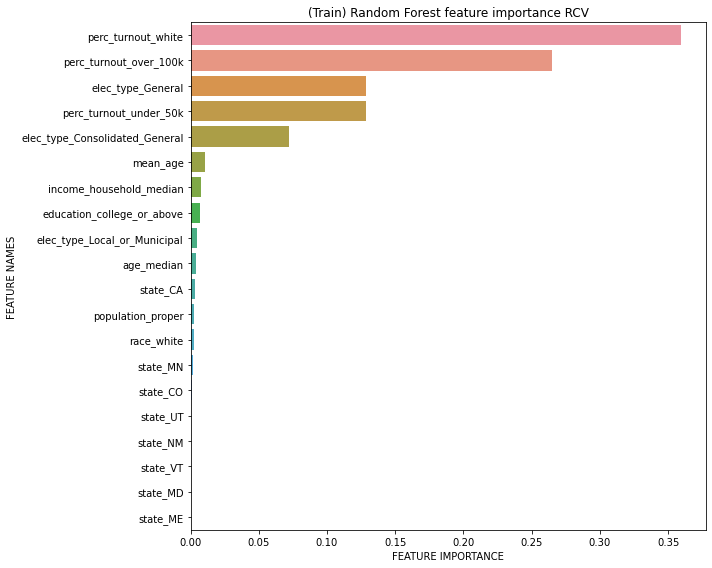

In [32]:
plot_feature_importance(rcv_rf.feature_importances_, rcv_data.columns, 
                        fig_title ='(Train) Random Forest feature importance RCV', 
                        file_name = 'RF_feature_imp_RCV')

### Non-RCV

In [33]:
#implement random forest
non_rcv_df = selected_df[selected_df['rcv'] == 0]
non_rcv_target = non_rcv_df['turnout']
non_rcv_data = non_rcv_df.drop(columns=['turnout', 'rcv','Residence_Addresses_City'])

non_rcv_rf = RandomForestRegressor(bootstrap = True, random_state = 0, oob_score = True,
                                   max_depth= None, max_features= 16, n_estimators = 100)
non_rcv_rf.fit(non_rcv_data, non_rcv_target)


non_rcv_pred = non_rcv_rf.predict(non_rcv_data)

print("Non RCV Cross Validation")
rf_nonrcv_cv = get_metrics_CV(non_rcv_rf, non_rcv_data, non_rcv_target)
rf_nonrcv_cv.columns = ['metric', 'rf_nonrcv_cv']
print(rf_nonrcv_cv)


Non RCV Cross Validation
Cross validation Mean Absolute Error score: 0.011
Cross validation Mean Squared Error score: 0.0
Cross validation R-sqaured score: 0.993
                metric  rf_nonrcv_cv
0  Mean_Absolute_Error         0.011
1   Mean_Squared_Error         0.000
2      R_squared_score         0.993


In [34]:
#generate and print ordered list of feature importance scores
non_rcv_sorted_features, non_rcv_sorted_feature_importance = ordered_feature_importance(non_rcv_data.columns, non_rcv_rf.feature_importances_, n=len(non_rcv_data.columns))

Feature 0 (perc_turnout_white) importance: 0.6764810893129295
Feature 1 (perc_turnout_over_100k) importance: 0.2766448258829627
Feature 2 (perc_turnout_under_50k) importance: 0.04198318885026689
Feature 3 (race_white) importance: 0.0014862305984526727
Feature 4 (education_college_or_above) importance: 0.0009615050971718061
Feature 5 (population_proper) importance: 0.0007854172628943563
Feature 6 (mean_age) importance: 0.0005068627861727281
Feature 7 (income_household_median) importance: 0.0004715993930695995
Feature 8 (age_median) importance: 0.0003571642063632902
Feature 9 (state_CA) importance: 7.471714641762669e-05
Feature 10 (state_NM) importance: 5.957251783013597e-05
Feature 11 (state_CO) importance: 4.9984188130537605e-05
Feature 12 (state_UT) importance: 2.5878337957268702e-05
Feature 13 (state_MN) importance: 2.506645019072424e-05
Feature 14 (state_MD) importance: 2.4079554547632235e-05
Feature 15 (state_ME) importance: 2.1631734650503944e-05
Feature 16 (elec_type_Consolidated

In [35]:
# #plot feature importance
# plt.bar(np.arange(len(non_rcv_sorted_features)), non_rcv_sorted_feature_importance)
# plt.title('Random Forest Feature Importance')
# plt.ylabel('Feature importance')
# plt.xlabel('Ordered feature number')

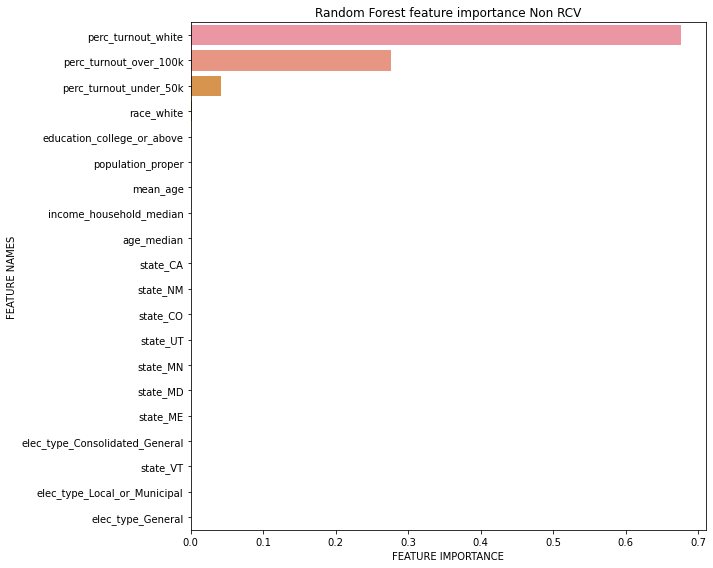

In [36]:
plot_feature_importance(non_rcv_rf.feature_importances_, non_rcv_data.columns, 
                        fig_title = 'Random Forest feature importance Non RCV', 
                        file_name = 'RF_feature_imp_Non_RCV')


### RCV vs. Non-RCV

In [37]:
#Match ranking of feature importance
rcv_v_nonrcv_df = pd.DataFrame({'rcv_feature': rcv_sorted_features, 'rcv_importance': rcv_sorted_feature_importance,
                  'non_rcv_feature': non_rcv_sorted_features, 'non_rcv_importance': non_rcv_sorted_feature_importance})
rcv_v_nonrcv_df

,rcv_feature,rcv_importance,non_rcv_feature,non_rcv_importance
0,perc_turnout_white,0.359471,perc_turnout_white,0.676481
1,perc_turnout_over_100k,0.265172,perc_turnout_over_100k,0.276645
2,elec_type_General,0.128872,perc_turnout_under_50k,0.041983
3,perc_turnout_under_50k,0.128530,race_white,0.001486
4,elec_type_Consolidated_General,0.072391,education_college_or_above,0.000962
5,mean_age,0.010476,population_proper,0.000785
6,income_household_median,0.007568,mean_age,0.000507
7,education_college_or_above,0.007118,income_household_median,0.000472
8,elec_type_Local_or_Municipal,0.004977,age_median,0.000357
9,age_median,0.003958,state_CA,0.000075


In [38]:
#Match features
nonrcv_df = pd.DataFrame({'feature': non_rcv_sorted_features, 'importance_nonrcv': non_rcv_sorted_feature_importance})
rcv_df = pd.DataFrame({'feature': rcv_sorted_features, 'importance_rcv': rcv_sorted_feature_importance})
rcv_v_nonrcv_df = nonrcv_df.merge(rcv_df, on = "feature")
rcv_v_nonrcv_df.head()

,feature,importance_nonrcv,importance_rcv
0,perc_turnout_white,0.676481,0.359471
1,perc_turnout_over_100k,0.276645,0.265172
2,perc_turnout_under_50k,0.041983,0.128530
3,race_white,0.001486,0.002147
4,education_college_or_above,0.000962,0.007118


In [39]:
rcv_v_nonrcv_df = pd.melt(rcv_v_nonrcv_df, id_vars=['feature'], value_vars=['importance_nonrcv','importance_rcv'])
rcv_v_nonrcv_df.head()

,feature,variable,value
0,perc_turnout_white,importance_nonrcv,0.676481
1,perc_turnout_over_100k,importance_nonrcv,0.276645
2,perc_turnout_under_50k,importance_nonrcv,0.041983
3,race_white,importance_nonrcv,0.001486
4,education_college_or_above,importance_nonrcv,0.000962


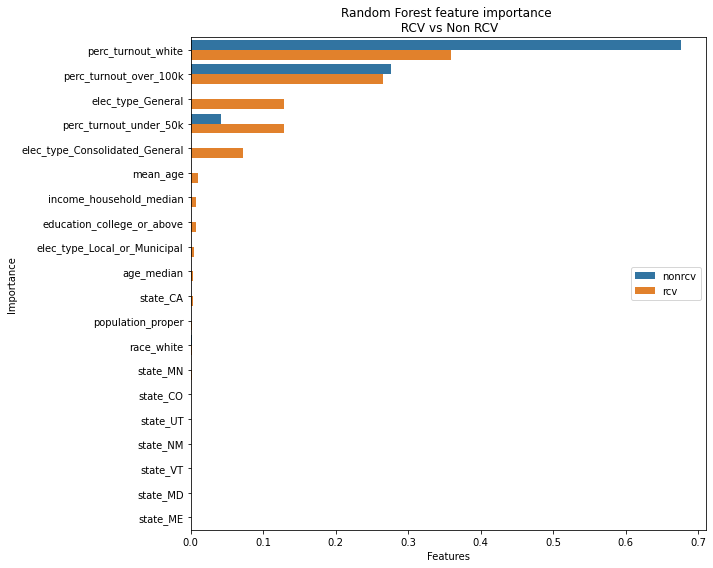

In [40]:
# Plotting
import seaborn as sns 

#Create arrays from feature importance and feature names
variable = np.array(rcv_v_nonrcv_df['variable'])
value = np.array(rcv_v_nonrcv_df['value'])
feature_names = np.array(rcv_v_nonrcv_df['feature'])

#Create a DataFrame using a Dictionary
data={'feature_names':feature_names,'variable':variable,'value':value}
fi_df = pd.DataFrame(data)
fi_df = fi_df.replace({'importance_nonrcv': 'nonrcv', 'importance_rcv': 'rcv'})

#Sort the DataFrame in order decreasing feature importance
fi_df.sort_values(by=['value'], ascending=False,inplace=True)

plt.figure(figsize=(10,8))
palette ={"nonrcv": "C0", "rcv": "C1"}

sns.barplot(x=fi_df['value'], y=fi_df['feature_names'], hue = fi_df['variable'], palette=palette)

plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Random Forest feature importance \n RCV vs Non RCV')
plt.legend(loc='center right')
plt.tight_layout()
#plt.savefig(f'../data/plots/RF_feature_imp_RCV_vs_Non_RCV.jpg')


### Linear Regression for Turnout

In [41]:
# importing modules and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


In [42]:
num_cols = ['population_proper', 'age_median', 'income_household_median', 'education_college_or_above', 'race_white']

ct = ColumnTransformer([
        ('somename', StandardScaler(), num_cols)
    ], remainder='passthrough')

ct.fit(X_train)
scaled_X_train = pd.DataFrame(ct.transform(X_train), columns = X_train.columns)

scaled_X_test = pd.DataFrame(ct.transform(X_test), columns = X_test.columns)
scaled_X_train.head()


,rcv,population_proper,age_median,income_household_median,education_college_or_above,race_white,elec_type_Consolidated_General,elec_type_General,elec_type_Local_or_Municipal,state_CA,state_CO,state_MD,state_ME,state_MN,state_NM,state_UT,state_VT
0,0.476714,0.000962,0.083024,0.530338,-0.071154,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.369441,1.190601,3.857929,2.608188,-1.790374,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.491529,-1.846110,-0.902002,0.390970,0.472473,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.185960,0.548822,1.235604,0.574682,-0.974934,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.473674,0.204453,-0.127322,1.328537,0.866602,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
#implement random forest
linreg = LinearRegression()

linreg.fit(scaled_X_train, y_train)
train_pred = linreg.predict(scaled_X_train)
test_pred = linreg.predict(scaled_X_test)


print("Train")
linreg_overall_train = get_metrics(y_train, train_pred)
linreg_overall_train.columns = ['metric', 'linreg_overall_train']
print(linreg_overall_train)

print("Test")
linreg_overall_test = get_metrics(y_test, test_pred)
linreg_overall_test.columns = ['metric', 'linreg_overall_test']
print(linreg_overall_test)

Train
Mean Absolute Error: 0.047
Mean Squared Error: 0.004
R-squared scores: 0.911
                metric  linreg_overall_train
0  Mean_Absolute_Error              0.046740
1   Mean_Squared_Error              0.003537
2      R_squared_score              0.910990
Test
Mean Absolute Error: 0.046
Mean Squared Error: 0.004
R-squared scores: 0.909
                metric  linreg_overall_test
0  Mean_Absolute_Error             0.046373
1   Mean_Squared_Error             0.003670
2      R_squared_score             0.909287


In [44]:
coefficients = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(linreg.coef_))], axis = 1)
coefficients.columns = ['feature', 'linreg_coefficient']

coefficients.sort_values('linreg_coefficient', ascending = False)

,feature,linreg_coefficient
7,elec_type_General,0.242101
10,state_CO,0.083434
13,state_MN,0.046519
3,income_household_median,0.034588
15,state_UT,0.028851
1,population_proper,0.025429
4,education_college_or_above,0.013959
5,race_white,0.006136
0,rcv,0.004822
9,state_CA,-0.007568


### Compare Random Forest and Linear Regression for Turnout

In [45]:
pd.merge(linreg_overall_train, rf_overall_train, on = "metric")


,metric,linreg_overall_train,rf_overall_train
0,Mean_Absolute_Error,0.046740,0.014263
1,Mean_Squared_Error,0.003537,0.000335
2,R_squared_score,0.910990,0.991566


In [46]:
pd.merge(linreg_overall_test, rf_overall_test, on = "metric")


,metric,linreg_overall_test,rf_overall_test
0,Mean_Absolute_Error,0.046373,0.039480
1,Mean_Squared_Error,0.003670,0.002681
2,R_squared_score,0.909287,0.933744


### P-value from Linear Regression Model for Turnout

In [47]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


                            OLS Regression Results                            
Dep. Variable:                turnout   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     189.0
Date:                Mon, 21 Nov 2022   Prob (F-statistic):          9.08e-136
Time:                        19:54:14   Log-Likelihood:                 411.18
No. Observations:                 293   AIC:                            -790.4
Df Residuals:                     277   BIC:                            -731.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


# Model Implementation: White Share of Voters

In [48]:
# split the data in 80:20 for train:test dataset
train_size=0.8

X = selected_df.drop(columns=['turnout',
                              'Residence_Addresses_City', 
                              'perc_turnout_white', 
                              'mean_age', 
                              'perc_turnout_under_50k',
                              'perc_turnout_over_100k'])
y = df['perc_turnout_white']

# In the first step we will split the data in training and remaining dataset
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8)

print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_test.shape)

(293, 17)
(293,)
(74, 17)
(74,)


(None, None)

In [49]:
#implement random forest
rf_race = RandomForestRegressor()

# n_estimators (The number of trees in the forest) default is 100, set 10, 20, 30 
# max_features: “auto”=n_features, “sqrt” =sqrt(n_features), “log2”=log2(n_features)

tuned_parameters = {'n_estimators': [10, 50, 100], 'max_depth': [None, 2, 3], 'max_features': [4, 8, 16, 20, 24]}
    
clf_race = GridSearchCV(RandomForestRegressor(bootstrap = True, random_state = 0), 
                   tuned_parameters, cv=5, 
                   n_jobs=-1, verbose=1)

clf_race.fit(X_train, y_train)

clf_race.score(X_train, y_train)
best_params_race = clf_race.best_params_ 
best_params_race

Fitting 5 folds for each of 45 candidates, totalling 225 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.90605857 0.92045653 0.92288784 0.91974893 0.92578364 0.92713006
 0.91520228 0.91929036 0.91942214        nan        nan        nan
        nan        nan        nan 0.71697772 0.72949969 0.74942011
 0.85222327 0.85656767 0.8557068  0.86818906 0.87231939 0.87246902
        nan        nan        nan        nan        nan        nan
 0.84046395 0.85137217 0.84259646 0.88839041 0.88871039 0.88909044
 0.8924518  0.89553163 0.89554569        nan        nan        nan
        nan        nan        nan]
  warnings.warn(


{'max_depth': None, 'max_features': 8, 'n_estimators': 100}

In [50]:
best_model_race = RandomForestRegressor(bootstrap = True, random_state = 0, max_depth= None, max_features= 8, n_estimators = 100)

best_model_race.fit(X_train, y_train)

train_pred = best_model_race.predict(X_train)
test_pred = best_model_race.predict(X_test)
    
print("Train")
rf_overall_train = get_metrics(y_train, train_pred)
rf_overall_train.columns = ['metric', 'rf_overall_train']

print("Test")
rf_overall_test = get_metrics(y_test, test_pred)
rf_overall_test.columns = ['metric', 'rf_overall_test']

Train
Mean Absolute Error: 1.54
Mean Squared Error: 4.398
R-squared scores: 0.99
Test
Mean Absolute Error: 3.884
Mean Squared Error: 23.714
R-squared scores: 0.944


In [51]:
sorted_features, sorted_feature_importance = ordered_feature_importance(X.columns, best_model_race.feature_importances_, n=len(X.columns))

Feature 0 (elec_type_General) importance: 0.5282482440369161
Feature 1 (elec_type_Consolidated_General) importance: 0.1690980836990091
Feature 2 (elec_type_Local_or_Municipal) importance: 0.09703078796889714
Feature 3 (education_college_or_above) importance: 0.044901275154760785
Feature 4 (state_CO) importance: 0.03128307551012715
Feature 5 (income_household_median) importance: 0.02757955961148675
Feature 6 (age_median) importance: 0.02737814067128247
Feature 7 (state_MN) importance: 0.02187393896167286
Feature 8 (race_white) importance: 0.017371045078287083
Feature 9 (population_proper) importance: 0.011463054432070966
Feature 10 (state_NM) importance: 0.011333336194354149
Feature 11 (state_UT) importance: 0.0037715716100308046
Feature 12 (state_VT) importance: 0.0025295357921449094
Feature 13 (rcv) importance: 0.0018327123545624003
Feature 14 (state_CA) importance: 0.0015561678394020535
Feature 15 (state_MD) importance: 0.0013799915285744872
Feature 16 (state_ME) importance: 0.001369

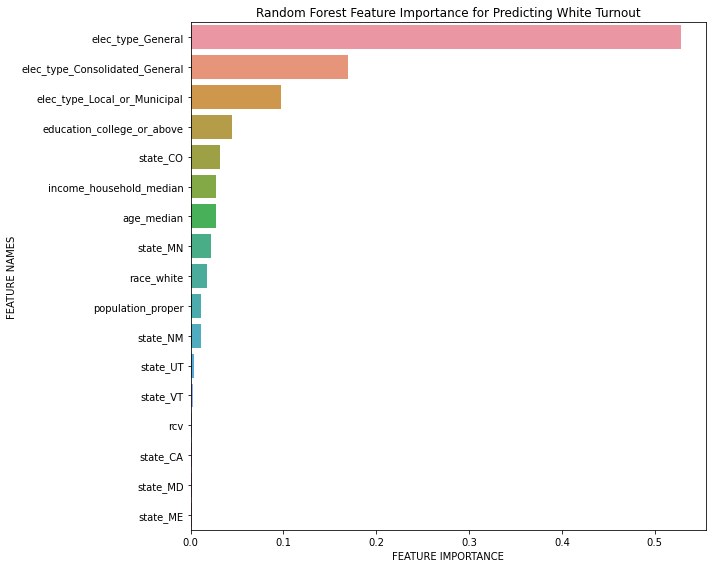

In [52]:
plot_feature_importance(best_model_race.feature_importances_, X.columns,
                        fig_title = 'Random Forest Feature Importance for Predicting White Turnout', 
                        file_name = 'RF_feature_imp_supervised_overall')

# Model Implementation: Average Age

In [53]:
# split the data in 80:20 for train:test dataset
train_size=0.8

X = selected_df.drop(columns=['turnout',
                              'Residence_Addresses_City', 
                              'perc_turnout_white', 
                              'mean_age', 
                              'perc_turnout_under_50k',
                              'perc_turnout_over_100k'])
y = df['mean_age']

# In the first step we will split the data in training and remaining dataset
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8)

print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_test.shape)

(293, 17)
(293,)
(74, 17)
(74,)


(None, None)

In [54]:
#implement random forest
rf_age = RandomForestRegressor()

# n_estimators (The number of trees in the forest) default is 100, set 10, 20, 30 
# max_features: “auto”=n_features, “sqrt” =sqrt(n_features), “log2”=log2(n_features)

tuned_parameters = {'n_estimators': [10, 50, 100], 'max_depth': [None, 2, 3], 'max_features': [4, 8, 16, 20, 24]}
    
clf_age = GridSearchCV(RandomForestRegressor(bootstrap = True, random_state = 0), 
                   tuned_parameters, cv=5, 
                   n_jobs=-1, verbose=1)

clf_age.fit(X_train, y_train)

clf_age.score(X_train, y_train)
best_params_age = clf_age.best_params_ 
best_params_age

Fitting 5 folds for each of 45 candidates, totalling 225 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.63949846 0.68059963 0.68406128 0.64523225 0.66702779 0.67128938
 0.64130139 0.66877209 0.66804356        nan        nan        nan
        nan        nan        nan 0.43272524 0.43149592 0.43263463
 0.47215429 0.4912617  0.49669493 0.50826609 0.5214193  0.52215985
        nan        nan        nan        nan        nan        nan
 0.52908058 0.53777633 0.5301086  0.55223945 0.57001262 0.57729219
 0.553756   0.59065069 0.59050103        nan        nan        nan
        nan        nan        nan]
  warnings.warn(


{'max_depth': None, 'max_features': 4, 'n_estimators': 100}

In [55]:
best_model_age = RandomForestRegressor(bootstrap = True, random_state = 0, max_depth= None, max_features= 16, n_estimators = 50)

best_model_age.fit(X_train, y_train)

train_pred = best_model_age.predict(X_train)
test_pred = best_model_age.predict(X_test)
    
print("Train")
rf_overall_train = get_metrics(y_train, train_pred)
rf_overall_train.columns = ['metric', 'rf_overall_train']

print("Test")
rf_overall_test = get_metrics(y_test, test_pred)
rf_overall_test.columns = ['metric', 'rf_overall_test']

Train
Mean Absolute Error: 0.596
Mean Squared Error: 0.66
R-squared scores: 0.957
Test
Mean Absolute Error: 1.851
Mean Squared Error: 6.46
R-squared scores: 0.681


In [56]:
sorted_features, sorted_feature_importance = ordered_feature_importance(X.columns, best_model_age.feature_importances_, n=len(X.columns))

Feature 0 (elec_type_General) importance: 0.3731031185396862
Feature 1 (age_median) importance: 0.2858236029919485
Feature 2 (income_household_median) importance: 0.09844111609144829
Feature 3 (population_proper) importance: 0.08113773046370878
Feature 4 (education_college_or_above) importance: 0.0513473249485738
Feature 5 (race_white) importance: 0.03891861693430103
Feature 6 (elec_type_Consolidated_General) importance: 0.013625109199277763
Feature 7 (elec_type_Local_or_Municipal) importance: 0.011834294357277368
Feature 8 (state_UT) importance: 0.011405170208074623
Feature 9 (state_NM) importance: 0.011241830816043089
Feature 10 (state_CO) importance: 0.006780765470871795
Feature 11 (state_ME) importance: 0.005868548312519466
Feature 12 (rcv) importance: 0.004799462218438442
Feature 13 (state_CA) importance: 0.0022572451922651033
Feature 14 (state_MN) importance: 0.0020701892014410492
Feature 15 (state_MD) importance: 0.0011448064337257462
Feature 16 (state_VT) importance: 0.00020106

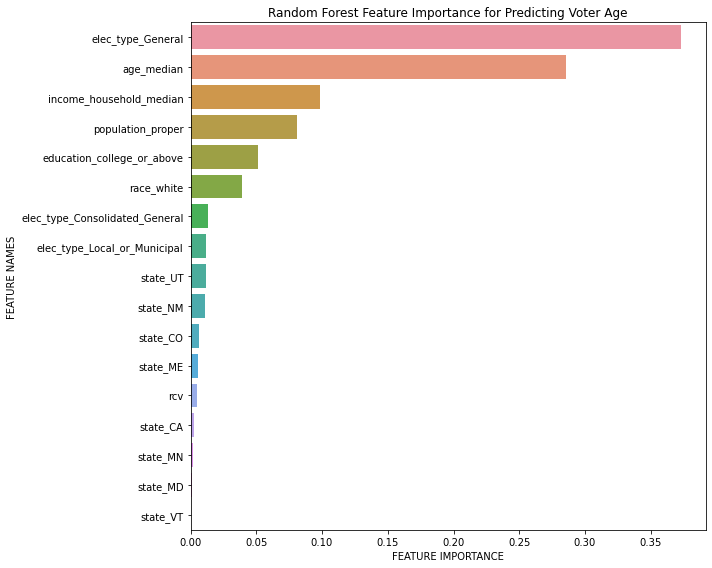

In [57]:
plot_feature_importance(best_model_age.feature_importances_, X.columns,
                        fig_title = 'Random Forest Feature Importance for Predicting Voter Age', 
                        file_name = 'RF_feature_imp_supervised_overall')

# Model Implementation: Income < 40K

In [58]:
# split the data in 80:20 for train:test dataset
train_size=0.8

X = selected_df.drop(columns=['turnout',
                              'Residence_Addresses_City', 
                              'perc_turnout_white', 
                              'mean_age', 
                              'perc_turnout_under_50k',
                              'perc_turnout_over_100k'])
y = df['perc_turnout_under_50k']

# In the first step we will split the data in training and remaining dataset
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8)

print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_test.shape)

(293, 17)
(293,)
(74, 17)
(74,)


(None, None)

In [59]:
#implement random forest
rf_income_less_than_40k = RandomForestRegressor()

# n_estimators (The number of trees in the forest) default is 100, set 10, 20, 30 
# max_features: “auto”=n_features, “sqrt” =sqrt(n_features), “log2”=log2(n_features)

tuned_parameters = {'n_estimators': [10, 50, 100], 'max_depth': [None, 2, 3], 'max_features': [4, 8, 16, 20, 24]}
    
clf_income_less_than_40k = GridSearchCV(RandomForestRegressor(bootstrap = True, random_state = 0), 
                   tuned_parameters, cv=5, 
                   n_jobs=-1, verbose=1)

clf_income_less_than_40k.fit(X_train, y_train)

clf_income_less_than_40k.score(X_train, y_train)
best_params_income_less_than_40k = clf_income_less_than_40k.best_params_ 
best_params_income_less_than_40k

Fitting 5 folds for each of 45 candidates, totalling 225 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.86364271 0.87627777 0.88133181 0.86127352 0.87677692 0.8789323
 0.8492529  0.86599594 0.86736614        nan        nan        nan
        nan        nan        nan 0.65593777 0.66566539 0.67607454
 0.75947302 0.75340813 0.7513055  0.74662462 0.75661758 0.75377844
        nan        nan        nan        nan        nan        nan
 0.74201666 0.76994226 0.77219629 0.79942089 0.80602487 0.80552779
 0.79485918 0.80772106 0.80606203        nan        nan        nan
        nan        nan        nan]
  warnings.warn(


{'max_depth': None, 'max_features': 4, 'n_estimators': 100}

In [60]:
best_model_income_less_than_40k = RandomForestRegressor(bootstrap = True, random_state = 0, max_depth= None, max_features= 4, n_estimators = 100)

best_model_income_less_than_40k.fit(X_train, y_train)

train_pred = best_model_income_less_than_40k.predict(X_train)
test_pred = best_model_income_less_than_40k.predict(X_test)
    
print("Train")
rf_overall_train = get_metrics(y_train, train_pred)
rf_overall_train.columns = ['metric', 'rf_overall_train']

print("Test")
rf_overall_test = get_metrics(y_test, test_pred)
rf_overall_test.columns = ['metric', 'rf_overall_test']

Train
Mean Absolute Error: 0.021
Mean Squared Error: 0.001
R-squared scores: 0.983
Test
Mean Absolute Error: 0.061
Mean Squared Error: 0.006
R-squared scores: 0.888


In [61]:
sorted_features, sorted_feature_importance = ordered_feature_importance(X.columns, best_model_income_less_than_40k.feature_importances_, n=len(X.columns))

Feature 0 (elec_type_General) importance: 0.3893995966384594
Feature 1 (elec_type_Consolidated_General) importance: 0.14471310552962538
Feature 2 (elec_type_Local_or_Municipal) importance: 0.0998644925558446
Feature 3 (income_household_median) importance: 0.0770846919995845
Feature 4 (education_college_or_above) importance: 0.06857568726763029
Feature 5 (race_white) importance: 0.047276676139640685
Feature 6 (age_median) importance: 0.044803769002248216
Feature 7 (state_NM) importance: 0.04047962591922049
Feature 8 (population_proper) importance: 0.031601728695047
Feature 9 (state_MN) importance: 0.013664238237096832
Feature 10 (state_CO) importance: 0.013536721519584799
Feature 11 (state_UT) importance: 0.00720057433116912
Feature 12 (state_CA) importance: 0.006477969629011308
Feature 13 (state_ME) importance: 0.004832517666453104
Feature 14 (rcv) importance: 0.004298785495425839
Feature 15 (state_VT) importance: 0.0033562532059073884
Feature 16 (state_MD) importance: 0.00283356616805

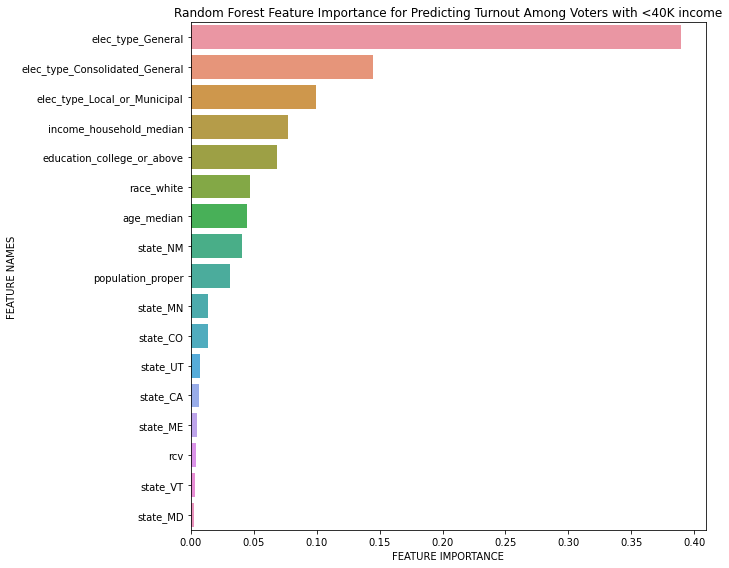

In [62]:
plot_feature_importance(best_model_income_less_than_40k.feature_importances_, X.columns,
                        fig_title = 'Random Forest Feature Importance for Predicting Turnout Among Voters with <40K income', 
                        file_name = 'RF_feature_imp_supervised_overall')

# Model Implementation: Income > 100K

In [63]:
# split the data in 80:20 for train:test dataset
train_size=0.8

X = selected_df.drop(columns=['turnout',
                              'Residence_Addresses_City', 
                              'perc_turnout_white', 
                              'mean_age', 
                              'perc_turnout_under_50k',
                              'perc_turnout_over_100k'])
y = df['perc_turnout_over_100k']

# In the first step we will split the data in training and remaining dataset
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8)

print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_test.shape)

(293, 17)
(293,)
(74, 17)
(74,)


(None, None)

In [64]:
#implement random forest
rf_income_over_100k = RandomForestRegressor()

# n_estimators (The number of trees in the forest) default is 100, set 10, 20, 30 
# max_features: “auto”=n_features, “sqrt” =sqrt(n_features), “log2”=log2(n_features)

tuned_parameters = {'n_estimators': [10, 50, 100], 'max_depth': [None, 2, 3], 'max_features': [4, 8, 16, 20, 24]}
    
clf_income_over_100k = GridSearchCV(RandomForestRegressor(bootstrap = True, random_state = 0), 
                   tuned_parameters, cv=5, 
                   n_jobs=-1, verbose=1)

clf_income_over_100k.fit(X_train, y_train)

clf_income_over_100k.score(X_train, y_train)
best_params_income_over_100k = clf_income_over_100k.best_params_ 
best_params_income_over_100k

Fitting 5 folds for each of 45 candidates, totalling 225 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.88657708 0.90261268 0.90771909 0.90343155 0.9079081  0.90758311
 0.89212003 0.90293224 0.90309769        nan        nan        nan
        nan        nan        nan 0.72830175 0.72885026 0.73561803
 0.84677696 0.84627126 0.84589406 0.85690564 0.8577875  0.85635039
        nan        nan        nan        nan        nan        nan
 0.81622425 0.82655294 0.82080022 0.87730583 0.87547025 0.87340723
 0.87255075 0.87749591 0.87671887        nan        nan        nan
        nan        nan        nan]
  warnings.warn(


{'max_depth': None, 'max_features': 8, 'n_estimators': 50}

In [68]:
best_model_income_over_100k = RandomForestRegressor(bootstrap = True, random_state = 0, max_depth= None, max_features= 8, n_estimators = 50)

best_model_income_over_100k .fit(X_train, y_train)

train_pred = best_model_income_over_100k.predict(X_train)
test_pred = best_model_income_over_100k.predict(X_test)
    
print("Train")
rf_overall_train = get_metrics(y_train, train_pred)
rf_overall_train.columns = ['metric', 'rf_overall_train']

print("Test")
rf_overall_test = get_metrics(y_test, test_pred)
rf_overall_test.columns = ['metric', 'rf_overall_test']

Train
Mean Absolute Error: 0.016
Mean Squared Error: 0.0
R-squared scores: 0.988
Test
Mean Absolute Error: 0.041
Mean Squared Error: 0.003
R-squared scores: 0.938


In [69]:
sorted_features, sorted_feature_importance = ordered_feature_importance(X.columns, best_model_income_over_100k.feature_importances_, n=len(X.columns))

Feature 0 (elec_type_General) importance: 0.5499752309825097
Feature 1 (elec_type_Consolidated_General) importance: 0.17321291150883047
Feature 2 (elec_type_Local_or_Municipal) importance: 0.0843133348573563
Feature 3 (education_college_or_above) importance: 0.04845565981317843
Feature 4 (state_CO) importance: 0.03318454236853808
Feature 5 (race_white) importance: 0.021394921262140057
Feature 6 (age_median) importance: 0.02119389942842757
Feature 7 (state_MN) importance: 0.01579780130662824
Feature 8 (income_household_median) importance: 0.015314061350429519
Feature 9 (population_proper) importance: 0.012893376598272832
Feature 10 (state_UT) importance: 0.005539356161535958
Feature 11 (state_NM) importance: 0.005303441093610831
Feature 12 (state_VT) importance: 0.004730931035630446
Feature 13 (state_CA) importance: 0.003035207321759862
Feature 14 (state_ME) importance: 0.0025529358606850537
Feature 15 (rcv) importance: 0.0024850593161955576
Feature 16 (state_MD) importance: 0.000617329

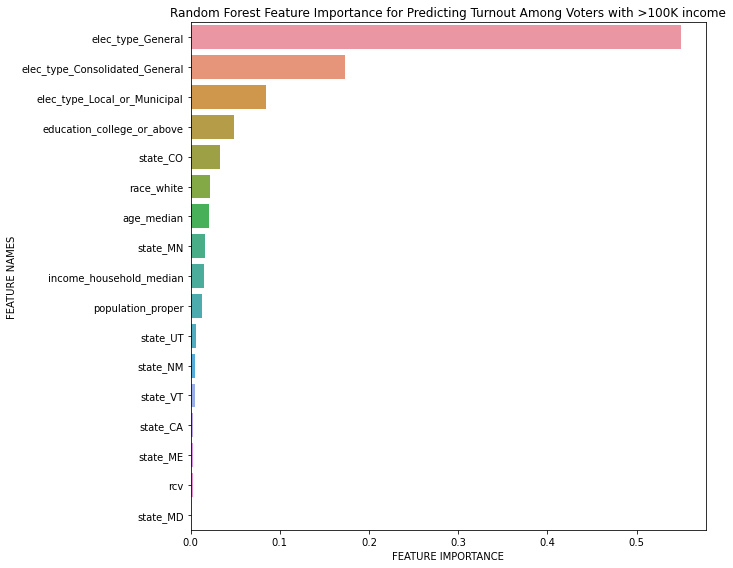

In [70]:
plot_feature_importance(best_model_income_over_100k.feature_importances_, X.columns,
                        fig_title = 'Random Forest Feature Importance for Predicting Turnout Among Voters with >100K income', 
                        file_name = 'RF_feature_imp_supervised_overall')